# Illustration of a Probabilistic Linear Solver

This notebook generates a plot illustrating the prior, actions and posterior of a probabilistic linear solver on a low-dimensional toy problem.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts} \usepackage{amsmath} \usepackage{bm}'

## Linear System

Generate a symmetric and diagonally dominant linear system $A x = b$.

In [72]:
import numpy as np
from scipy.sparse import diags
from probnum.linalg import problinsolve
from probnum.linops import SymmetricKronecker, Identity
from probnum.randprocs import kernels

# Random number generator
rng = np.random.default_rng(1)

# Random linear system
n = 5
k = int(n / 2)
X = np.linspace(-1, 1, n)
A = kernels.Matern(input_shape=(), nu=3.5, lengthscale=0.5).matrix(X)
b = -1.5 * rng.normal(size=(n, 1))

# Compute inverse and solution
Ainv = np.linalg.inv(A)
x = np.linalg.solve(A, b)

# Print matrix condition and eigenvalues
print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print(np.linalg.eigvals(A))

Matrix condition: 10.53
[2.12227944 1.4545497  0.81739556 0.20153713 0.40423816]


## Prior Distribution

In [73]:
from probnum.randvars import Normal

# Prior distribution on Ainv and A
covA = SymmetricKronecker(A=Identity(n))
Ainv0 = Normal(mean=Identity(n), cov=covA)
A0 = Normal(mean=Identity(n), cov=covA)

# Induced prior on x
x0 = Ainv0.mean @ b

## Solve Linear System

In [74]:
# Callback function to obtain search directions
S = []  # search directions
Y = []  # observations


def callback_searchdirs(xk, Ak, Ainvk, sk, yk, alphak, resid):
    S.append(sk)
    Y.append(yk)

In [77]:
# Solve linear system with probabilistic linear solver
xhat, Ahat, Ainvhat, info = problinsolve(A=A, b=b, Ainv0=Ainv0, maxiter=3, calibration=None, callback=callback_searchdirs)
print(info)

{'iter': 3, 'maxiter': 3, 'resid_l2norm': 0.3926637224561934, 'trace_sol_cov': 0.774048138158391, 'conv_crit': 'maxiter', 'rel_cond': None}


/home/j/Documents/professional/research/code/probnum/src/probnum/linalg/solvers/matrixbased.py:506: UserWarning: Iteration terminated. Solver reached the maximum number of iterations.
  warnings.warn(


## Sample from Posterior

In [78]:
# Draw samples
n_samples = 4
Ahatsamples = Ahat.sample(rng, n_samples)
Ainvsamples = Ainvhat.sample(rng, n_samples)
xsamples = xhat.sample(rng, n_samples)

## Plot

In [79]:
# Color map
cmap = "viridis"
matrix_stack = np.hstack(
    (
        A,
        b,
        Ahat.mean.todense(),
        Ainvhat.mean.todense(),
        np.squeeze(np.array(S)).T,
        np.squeeze(np.array(Y).T),
    )
)
vmax = 3
vmin = -vmax

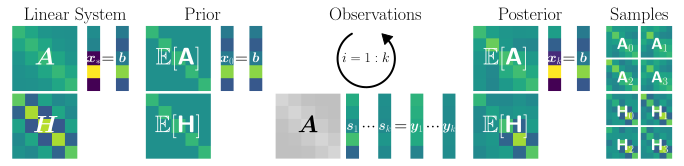

In [80]:
# Plot settings
title_x = 0.55
title_y = 0.5
eqsign_x = 0.5
eqsign_y = 0.5
eqsign_fontsize = 18

# Figure
fig = plt.figure(figsize=(12, 2.8), constrained_layout=False)

# Grids
gs0 = fig.add_gridspec(
    3,
    5,
    height_ratios=[0.25, 1, 1],
    width_ratios=[1, 1, 1.5, 1, 0.6],
    hspace=0.05,
    wspace=0.1,
)

widths0 = [5, 1, 0.25, 1]
heights0 = [4]
gs10 = gs0[1, 0].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs20 = gs0[2, 0].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs11 = gs0[1, 1].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs21 = gs0[2, 1].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs12 = gs0[1, 2].subgridspec(nrows=1, ncols=1, width_ratios=[5], height_ratios=heights0)
gs22 = gs0[2, 2].subgridspec(
    nrows=1,
    ncols=8,
    width_ratios=[4, 1, 0.5, 1, 0.5, 1, 0.5, 1],
    height_ratios=heights0,
)
gs13 = gs0[1, 3].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs23 = gs0[2, 3].subgridspec(
    nrows=1, ncols=4, width_ratios=widths0, height_ratios=heights0
)
gs14 = gs0[1, 4].subgridspec(nrows=1, ncols=1, width_ratios=[5], height_ratios=heights0)
gs24 = gs0[2, 4].subgridspec(nrows=1, ncols=1, width_ratios=[5], height_ratios=heights0)

# Add plots
def plot_matrix(
    gridspec, mat, title, fontsize=24, text_x=2, text_y=2, textcolor="white"
):
    ax = fig.add_subplot(gridspec)
    plt.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_axis_off()
    ax.text(
        text_x,
        text_y,
        title,
        size=fontsize,
        ha="center",
        va="center",
        color=textcolor,
        alpha=1,
    )


# Linear System
ax = fig.add_subplot(gs0[0, 0])
ax.text(title_x, title_y, "Linear System", va="center", ha="center", rotation=0)
ax.set_axis_off()
plot_matrix(gridspec=gs10[0, 0], mat=A, title="$\\bm{A}$")
plot_matrix(
    gridspec=gs10[0, 1], mat=x, title="$\\bm{x}_*$", text_x=0, text_y=2, fontsize=14
)
ax = fig.add_subplot(gs10[0, 2])
ax.set_axis_off()
ax.text(eqsign_x, eqsign_y, "$=$", va="center", ha="center", fontsize=eqsign_fontsize)
plot_matrix(
    gridspec=gs10[0, 3], mat=b, title="$\\bm{b}$", text_x=0, text_y=2, fontsize=14
)
plot_matrix(gridspec=gs20[0, 0], mat=Ainv, title="$\\bm{H}$")

# Prior
ax = fig.add_subplot(gs0[0, 1])
ax.text(eqsign_x, eqsign_y, "Prior", va="center", ha="center", rotation=0)
ax.set_axis_off()
plot_matrix(
    gridspec=gs11[0, 0],
    mat=A0.mean.todense(),
    title="$\mathbb{E}[\\bm{\\mathsf{A}}]$",
)
plot_matrix(
    gridspec=gs11[0, 1], mat=x0, title="$\\bm{x}_0$", text_x=0, text_y=2, fontsize=14
)
ax = fig.add_subplot(gs11[0, 2])
ax.set_axis_off()
ax.text(eqsign_x, eqsign_y, "$=$", va="center", ha="center", fontsize=eqsign_fontsize)
plot_matrix(
    gridspec=gs11[0, 3], mat=b, title="$\\bm{b}$", text_x=0, text_y=2, fontsize=14
)
plot_matrix(
    gridspec=gs21[0, 0],
    mat=Ainv0.mean.todense(),
    title="$\mathbb{E}[\\bm{\\mathsf{H}}]$",
)

# Observations
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad


def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_="black"):
    # Source: https://stackoverflow.com/questions/37512502/how-to-make-arrow-that-loops-in-matplotlib
    # ========Line
    arc = Arc(
        [centX, centY],
        radius,
        radius,
        angle=angle_,
        theta1=0,
        theta2=theta2_,
        capstyle="round",
        linestyle="-",
        lw=2,
        color=color_,
    )
    ax.add_patch(arc)

    # ========Create the arrow head
    endX = centX + (radius / 2) * np.cos(
        rad(theta2_ + angle_)
    )  # Do trig to determine end position
    endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

    ax.add_patch(  # Create triangle as arrow head
        RegularPolygon(
            (endX, endY),  # (x,y)
            3,  # number of vertices
            radius / 9,  # radius
            rad(angle_ + theta2_),  # orientation
            color=color_,
        )
    )
    ax.set_xlim([centX - radius, centY + radius]) and ax.set_ylim(
        [centY - radius, centY + radius]
    )
    # Make sure you keep the axes scaled or else arrow will distort


ax = fig.add_subplot(gs0[0, 2])
ax.text(title_x, title_y, "Observations", va="center", ha="center", rotation=0)
ax.set_axis_off()

ax = fig.add_subplot(gs12[0, 0])
drawCirc(ax, 1, 1, 1, 120, 285)
ax.set_axis_off()
ax.axis("equal")
ax.text(1, 1, "$i=1:k$", va="center", ha="center", fontsize=14)

ax = fig.add_subplot(gs22[0, 0])
plt.imshow(A, vmin=vmin, vmax=vmax, cmap="gray", alpha=0.5)
ax.text(2, 2, "$\\bm{A}$", size=24, ha="center", va="center")
ax.set_axis_off()

plot_matrix(
    gridspec=gs22[0, 1], mat=S[0], title="$\\bm{s}_1$", text_x=0, text_y=2, fontsize=14
)

ax = fig.add_subplot(gs22[0, 2])
ax.set_axis_off()
ax.text(
    eqsign_x,
    eqsign_y + 0.05,
    "$...$",
    va="center",
    ha="center",
    fontsize=eqsign_fontsize,
)

plot_matrix(
    gridspec=gs22[0, 3], mat=S[1], title="$\\bm{s}_k$", text_x=0, text_y=2, fontsize=14
)

ax = fig.add_subplot(gs22[0, 4])
ax.set_axis_off()
ax.text(eqsign_x, eqsign_y, "$=$", va="center", ha="center", fontsize=eqsign_fontsize)

plot_matrix(
    gridspec=gs22[0, 5],
    mat=Y[0],
    title="$\\bm{y}_1$",
    text_x=0,
    text_y=2,
    fontsize=14,
)

ax = fig.add_subplot(gs22[0, 6])
ax.set_axis_off()
ax.text(
    eqsign_x,
    eqsign_y + 0.05,
    "$...$",
    va="center",
    ha="center",
    fontsize=eqsign_fontsize,
)

plot_matrix(
    gridspec=gs22[0, 7],
    mat=Y[1],
    title="$\\bm{y}_k$",
    text_x=0,
    text_y=2,
    fontsize=14,
)

# Posterior
ax = fig.add_subplot(gs0[0, 3])
ax.text(eqsign_x, eqsign_y, "Posterior", va="center", ha="center", rotation=0)
ax.set_axis_off()
plot_matrix(
    gridspec=gs13[0, 0],
    mat=Ahat.mean.todense(),
    title="$\mathbb{E}[\\bm{\\mathsf{A}}]$",
)
plot_matrix(
    gridspec=gs13[0, 1],
    mat=xhat.mean[:, None],
    title="$\\bm{x}_k$",
    text_x=0,
    text_y=2,
    fontsize=14,
)
ax = fig.add_subplot(gs13[0, 2])
ax.set_axis_off()
ax.text(eqsign_x, eqsign_y, "$=$", va="center", ha="center", fontsize=eqsign_fontsize)
plot_matrix(
    gridspec=gs13[0, 3], mat=b, title="$\\bm{b}$", text_x=0, text_y=2, fontsize=14
)
plot_matrix(
    gridspec=gs23[0, 0],
    mat=Ainvhat.mean.todense(),
    title="$\mathbb{E}[\\bm{\\mathsf{H}}]$",
)

# Samples
ax = fig.add_subplot(gs0[0, 4])
ax.text(eqsign_x, eqsign_y, "Samples", va="center", ha="center", rotation=0)
ax.set_axis_off()

inner_grid = gs14[0, 0].subgridspec(2, 2, hspace=0.05, wspace=-0.1)
ax = fig.add_subplot(gs14[0, 0])
# plt.title("$\\bm{\\mathsf{A}}_1, \\bm{\\mathsf{A}}_2, ...$", fontsize=14)
ax.set_axis_off()
for i in range(n_samples):
    plot_matrix(
        inner_grid[i],
        Ahatsamples[i],
        "$\\bm{\\mathsf{A}}_" + str(i) + "$",
        fontsize=16,
        text_x=2.5,
        text_y=2.5,
    )

inner_grid = gs24[0, 0].subgridspec(2, 2, hspace=0.05, wspace=-0.1)
ax = fig.add_subplot(gs24[0, 0])
# plt.title("$\\bm{\\mathsf{H}}_1, \\bm{\\mathsf{H}}_2, ...$", fontsize=14)
ax.set_axis_off()
for i in range(n_samples):
    plot_matrix(
        inner_grid[i],
        Ainvsamples[i],
        "$\\bm{\\mathsf{H}}_" + str(i) + "$",
        fontsize=16,
        text_x=2.5,
        text_y=2.5,
    )

# Save plot to file
# plt.tight_layout(pad=0.15, h_pad=0, w_pad=0)
fig.savefig("../../figures/PLS_illustration.pdf", bbox_inches="tight", pad_inches=0)
plt.show()